# Gonads - PGCs palantir analysis

In [1]:
import palantir
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import os
import operator
import matplotlib.pyplot as plt

import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures_germcells/'
# sc.logging.print_versions()
# sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable
plt.show()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


## Load clustered data

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adataGC = sc.read(path_to_gonads+'FCA-gonads_germcellsClean_annotated.h5ad')
adata = sc.read(path_to_gonads+'FCA-gonads_rawcounts.h5ad')

In [3]:
adata = adata[[ i in adataGC.obs_names for i in adata.obs_names ]]

In [4]:
adataGC

AnnData object with n_obs × n_vars = 10993 × 24744
    obs: 'n_genes', 'sample', 'donor', 'location', 'stage', 'sex', 'study', 'batch_collection', 'enrichment', 'cryopreserved', 'TP', '10xKit', 'dig_protocol', 'percent_mito', 'n_counts', 'batch', 'low_ncounts', 'high_mito', 'low_ncounts_high_mito', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'lineages_v1', 'celltype_v1', 'lineage_v2', 'somatic_celltype_v2', 'PCW', 'sample_source', 'trimester', 'lineage', 'celltype_germcellDirty', 'leiden', 'leiden_R', 'celltype'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'n_cells-15', 'gene_

In [5]:
adata.obsm['X_umap'] = adataGC.obsm['X_umap']
adata.obsm['X_scVI'] = adataGC.obsm['X_scVI']
adata.obsp['connectivities'] = adataGC.obsp['connectivities']
adata.obsp['distances'] = adataGC.obsp['distances']
adata.uns['celltype_colors'] = adataGC.uns['celltype_colors']
adata.uns['neighbors'] = adataGC.uns['neighbors']

## Filter germ cells

In [6]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'FCA-gonads_germcellsClean_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()


cell_annot = metaF['celltype'].to_dict()
adata.obs['celltype'] = adata.obs_names.map(cell_annot).astype('category')
adata.obs['celltype'].value_counts()

PGC                  3764
oogonia_STRA8        2203
oogonia_meiotic      1875
pre_oocyte            812
oocyte                723
pre_spermatogonia     621
GC_mitotic            510
GC                    485
Name: celltype, dtype: int64

In [7]:
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype ]]
adata.obs['celltype'].value_counts()

PGC                  3764
oogonia_STRA8        2203
oogonia_meiotic      1875
pre_oocyte            812
oocyte                723
pre_spermatogonia     621
GC_mitotic            510
GC                    485
Name: celltype, dtype: int64

In [2]:
print(palantir.__version__)

1.0.0


findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


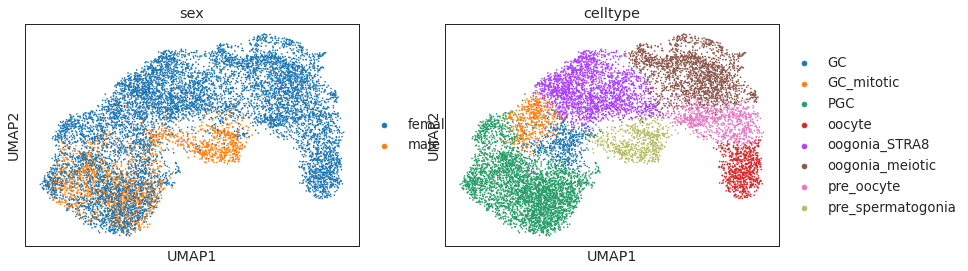

In [9]:
%matplotlib inline
sc.pl.umap(adata, color=['sex', 'celltype'])

## Downsample

In [10]:
target_cells = 500

adata.obs['cell'] = adata.obs.index
adata.obs['sex_fake'] = [ '--'+str(i)+'--' for i in adata.obs['celltype'].tolist() ] # this is ensure perfect match
adata.obs['sex_fake'] = adata.obs['sex_fake'].astype('category')
#adata.obs['sex_celltype'] = adata.obs.apply(lambda x: '_'.join(x[[ 'celltype', 'sex']]),axis=1)

adatas = [adata[adata.obs['sex_fake'].isin([cl])] for cl in adata.obs['sex_fake'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells, random_state=0)

adata_downsampled = adatas[0].concatenate(*adatas[1:])

Trying to set attribute `.obs` of view, copying.


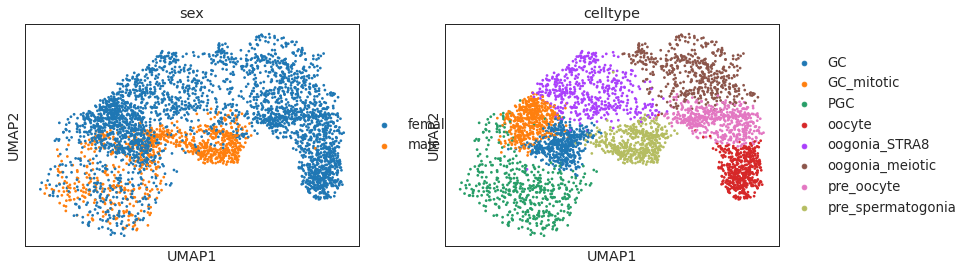

In [11]:
adata = adata[[ i in adata_downsampled.obs.cell.tolist() for i in adata.obs['cell'] ]]
adata
sc.pl.umap(adata, color=['sex', 'celltype'])

## Find root cell

In [12]:
index, value = max(enumerate(adata[:,'POU5F1'].X), key=operator.itemgetter(1))
start_cell = adata.obs.index[index]
start_cell

'HCA_F_GON10828899_CGATGTATCAGTTGAC'

Trying to set attribute `.uns` of view, copying.
<ipython-input-13-5499882dabf7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['rootcell'][index] = 1


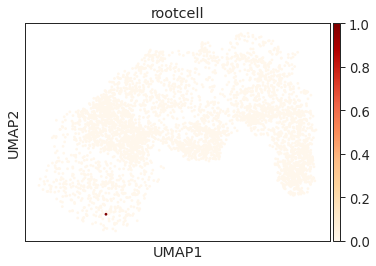

In [13]:
adata.uns['iroot'] = index
adata.obs['rootcell'] = 0
adata.obs['rootcell'][index] = 1

sc.pl.umap(adata,color='rootcell',color_map='OrRd')

In [14]:
start_cell

'HCA_F_GON10828899_CGATGTATCAGTTGAC'

## Run diffusion map
Determine the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [15]:
# sc.tl.diffmap(adata)
# sc.tl.dpt(adata, n_branchings=2, n_dcs=15)

## Run palantir

In [16]:
# ms_data = pd.DataFrame(adata.obsm['X_diffmap'],index=adata.obs_names)
# pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, knn=30)
# adata.obs['palantir_pseudotime'] = pr_res.pseudotime

## Visualize

In [17]:
# sc.pl.umap(adata, color=['stage',  'sex', 'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1', 'SYCP1', 'FIGLA', 'PIWIL4', 'PIWIL4', 'percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

In [18]:
# sc.pl.diffmap(adata, color=['stage',  'palantir_pseudotime', 'dpt_pseudotime', 'POU5F1','STRA8', 'SYCP1', 'FIGLA', 'PIWIL4','percent_mito'], save='_cluster_subset_pseudotime.pdf', ncols=2)

## Gene expression - palantir

#### Generate the norm expression matrix

In [19]:
adata_count = adata.copy()
sc.pp.filter_genes(adata_count, min_counts=3)
sc.pp.filter_cells(adata_count, min_genes=3)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
sc.pp.highly_variable_genes(adata_count, n_top_genes=2000)

m = adata_count.X.toarray()
norm_df = pd.DataFrame(data=m, index=adata_count.obs_names, columns=adata_count.var_names)

filtered out 5468 genes that are detected in less than 3 counts
normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA
    on highly variable genes
    with n_comps=1000
    finished (0:01:26)
computing PCA
    on highly variable genes
    with n_comps=379
    finished (0:00:27)
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


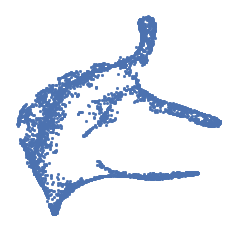

In [20]:
pca_projections, _ = palantir.utils.run_pca(adata_count)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)
tsne = palantir.utils.run_tsne(ms_data)
fig, ax = palantir.plot.plot_tsne(tsne)

#### Impute with MAGIC

In [21]:
imp_df = palantir.utils.run_magic_imputation(norm_df, dm_res)

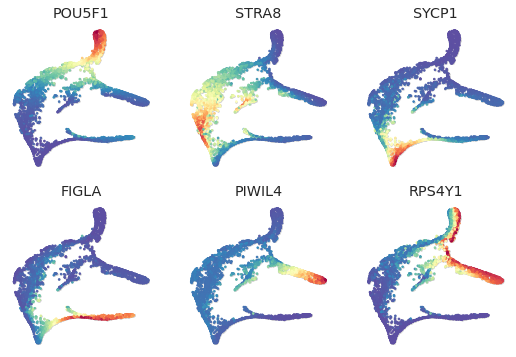

In [22]:
genes = ['POU5F1', 'STRA8', 'SYCP1', 'FIGLA', 'PIWIL4', 'RPS4Y1']
palantir.plot.plot_gene_expression(imp_df, tsne, genes, n_cols=3)
fig = plt.gcf()
fig.savefig('plot_gene_expression.pdf', dpi=1200)

#### Plot diffusion

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


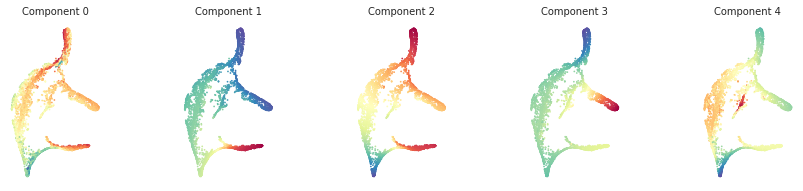

In [23]:
palantir.plot.plot_diffusion_components(tsne, dm_res)

#### Rename terminal states to reflect the known biology below

In [24]:
start_cell

'HCA_F_GON10828899_CGATGTATCAGTTGAC'

In [ ]:
# obtain pr_res object
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500)

In [26]:
pr_res.branch_probs.columns

Index(['FCA_GND8715519_GGTGTTATCTAGCACA', 'HD_F_GON9699332_CGGTTAAAGGAGTAGA'], dtype='object')

In [27]:
# adata.obs['branch_1'] = [i in pr_res.branch_probs.columns[0] for i in adata.obs_names ]
# adata.obs['branch_2'] = [i in pr_res.branch_probs.columns[1] for i in adata.obs_names ]
# sc.pl.umap(adata,color=['branch_1','branch_2'],color_map='OrRd')
# palantir.plot.highlight_cells_on_tsne(tsne, start_cell)
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[0])
# palantir.plot.highlight_cells_on_tsne(tsne, pr_res.branch_probs.columns[1])

In [28]:
pr_res.branch_probs.columns

Index(['FCA_GND8715519_GGTGTTATCTAGCACA', 'HD_F_GON9699332_CGGTTAAAGGAGTAGA'], dtype='object')

In [29]:
mapping = pd.Series(index=['pre_spematogonia', 'oocyte'])
mapping['oocyte'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmax()
mapping['pre_spematogonia'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
#mapping['PGC'] = tsne.loc[pr_res.branch_probs.columns, 'x'].idxmin()
#mapping['PGC'] = pr_res.branch_probs.columns.difference(mapping.values)
mapping = pd.Series(mapping.index, index=mapping)
mapping

<ipython-input-29-2072422e8a6a>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mapping = pd.Series(index=['pre_spematogonia', 'oocyte'])


HD_F_GON9699332_CGGTTAAAGGAGTAGA    pre_spematogonia
FCA_GND8715519_GGTGTTATCTAGCACA               oocyte
dtype: object

In [30]:
# pr_res.branch_probs.columns = mapping
# pr_res.branch_probs = pr_res.branch_probs.loc[:, ['Oocyte', 'Spermatocyte']]
# pr_res.branch_probs.head()

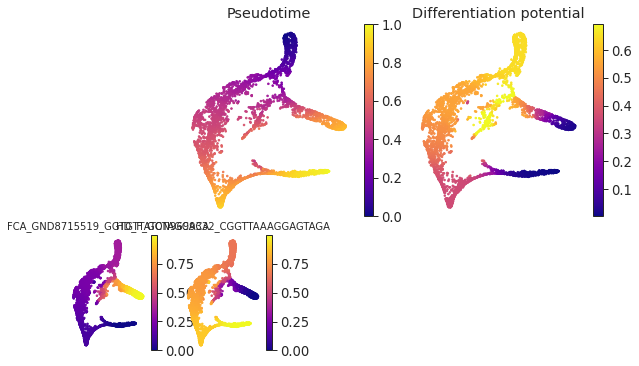

In [31]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()
# fig.savefig('figures_germcells/plot_palantir_results.pdf', dpi=1200)

## Gene expression trends

In [32]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

FCA_GND8715519_GGTGTTATCTAGCACA
Time for processing FCA_GND8715519_GGTGTTATCTAGCACA: 0.04692416985829671 minutes
HD_F_GON9699332_CGGTTAAAGGAGTAGA
Time for processing HD_F_GON9699332_CGGTTAAAGGAGTAGA: 0.0319736917813619 minutes


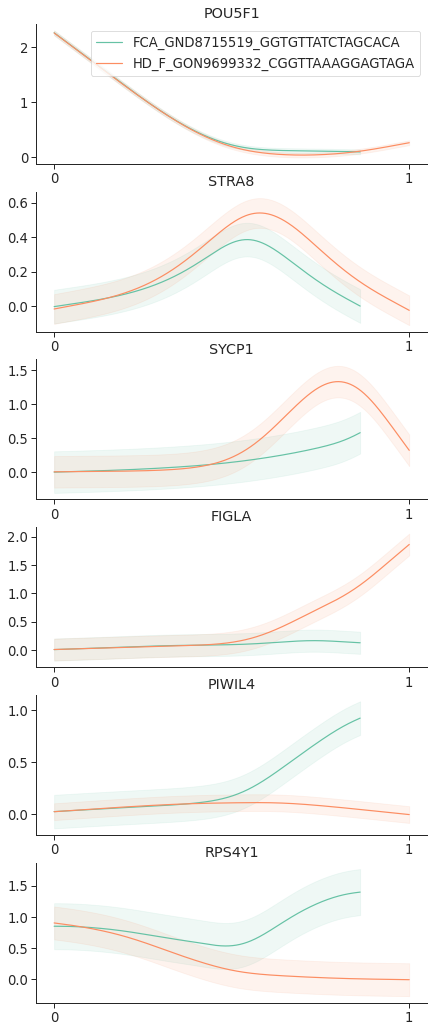

In [33]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

## Run palantir especifing endpoint as well

In [34]:
index, value = max(enumerate(adata[:,'POU5F1'].X), key=operator.itemgetter(1))
PGC = adata.obs.index[index]
PGC


index, value = max(enumerate(adata[:,'PIWIL4'].X), key=operator.itemgetter(1))
gonocyte = adata.obs.index[index]
gonocyte


index, value = max(enumerate(adata[:,'OOSP2'].X), key=operator.itemgetter(1))
oocyte = adata.obs.index[index]
oocyte

'HD_F_GON9883862_ACATCAGTCATACGGT'

In [35]:
terminal_states = pd.Series(['pre_spermatogonia', 'oocyte'], index=[ gonocyte, oocyte])
pr_res = palantir.core.run_palantir(ms_data, PGC, num_waypoints=500, terminal_states=terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0033136288324991862 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.0793532649676005 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9998
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [36]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

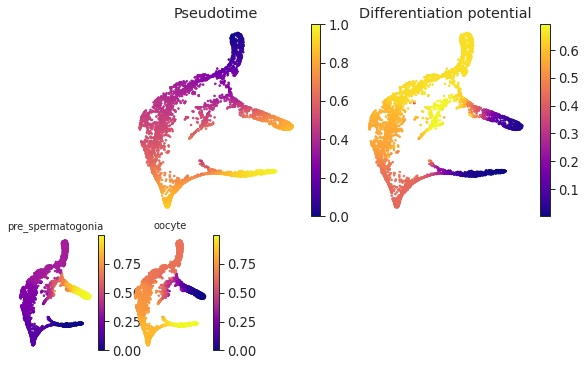

In [37]:
palantir.plot.plot_palantir_results(pr_res, tsne)
fig = plt.gcf()
fig.savefig('figures_germcells/plot_palantir_resultsEndpoint.pdf', dpi=1200)

In [38]:
gene_trends = palantir.presults.compute_gene_trends( pr_res, imp_df.loc[:, genes])

pre_spermatogonia
Time for processing pre_spermatogonia: 0.0474722146987915 minutes
oocyte
Time for processing oocyte: 0.03136284351348877 minutes


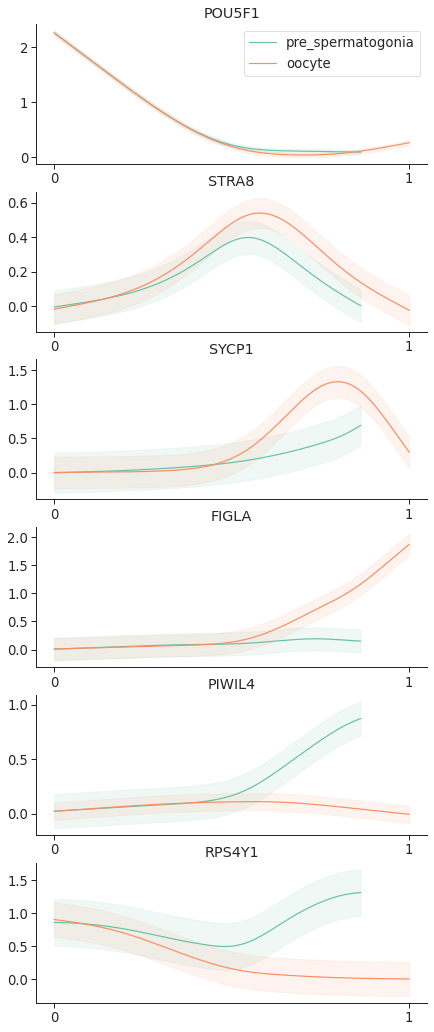

In [39]:
%matplotlib inline
palantir.plot.plot_gene_trends(gene_trends)

# Clustering

In [40]:
# clusters = palantir.utils.determine_cell_clusters(pca_projections, k=10)
clusters = adata.obs['celltype']

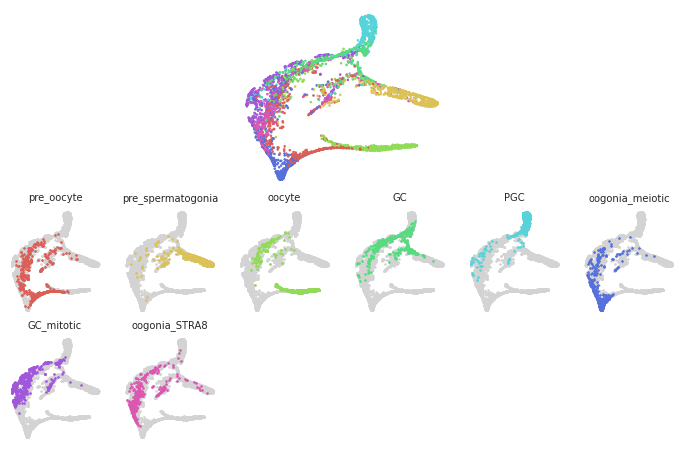

In [41]:
palantir.plot.plot_cell_clusters(tsne, clusters)
fig = plt.gcf()
fig.savefig('figures_germcells/plot_palantir_celltypes.pdf', dpi=1200)

In [42]:
adata.write('trj_palantir1_germcells.h5ad')